In [1]:
import saspy
saspy.__version__

'3.1.7'

In [42]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.version

In [3]:
import pandas as pd
from IPython.display import HTML

In [4]:
sas = saspy.SASsession(cfgname='winlocal')

SAS Connection established. Subprocess id is 10800



In [5]:
sas

Access Method         = IOM
SAS Config name       = winlocal
SAS Config file       = C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\saspy\sascfg_personal.py
WORK Path             = D:\opt\sasinside\SASWORK\_TD16576_SAS-AAP_\Prc2\
SAS Version           = 9.04.01M6P11072018
SASPy Version         = 3.1.7
Teach me SAS          = False
Batch                 = False
Results               = Pandas
SAS Session Encoding  = wlatin1
Python Encoding value = windows-1252
SAS process Pid value = 16576


In [6]:
 %%SAS
 proc corr data = sashelp.cars;
 var MSRP Invoice EngineSize Cylinders Horsepower MPG_City MPG_Highway Weight Wheelbase Length;
 run;

Please enter the name of the SAS Config you wish to run. Available Configs are: ['default', 'winlocal'] winlocal
SAS Connection established. Subprocess id is 20852



To Submit SAS Code Directly from Python


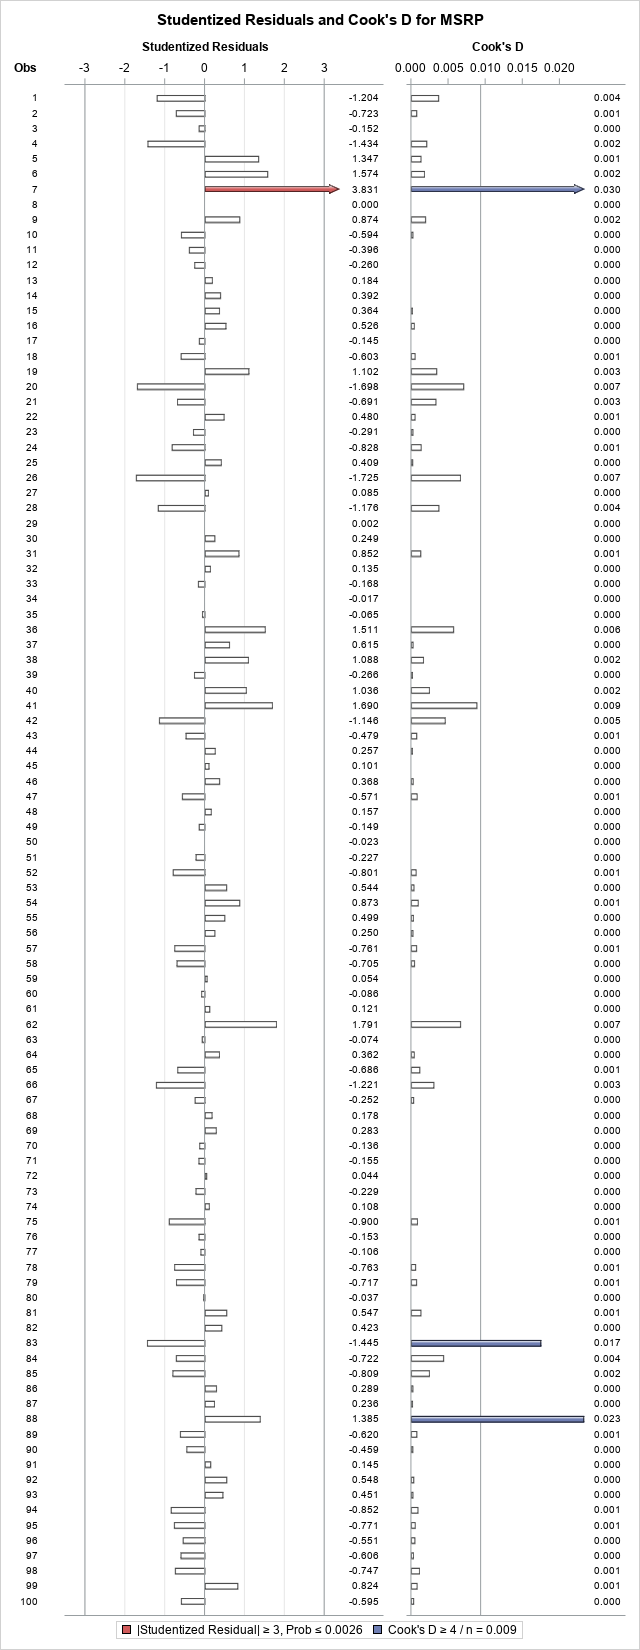
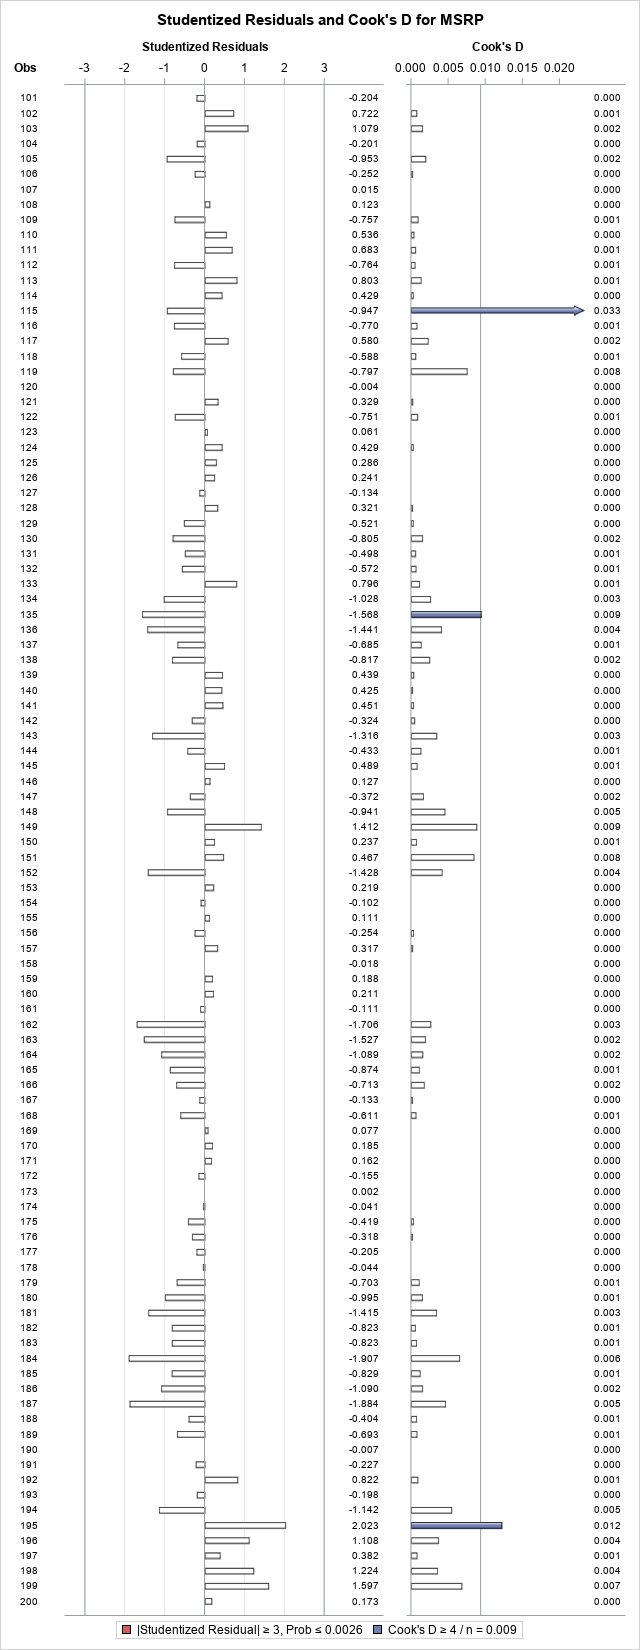
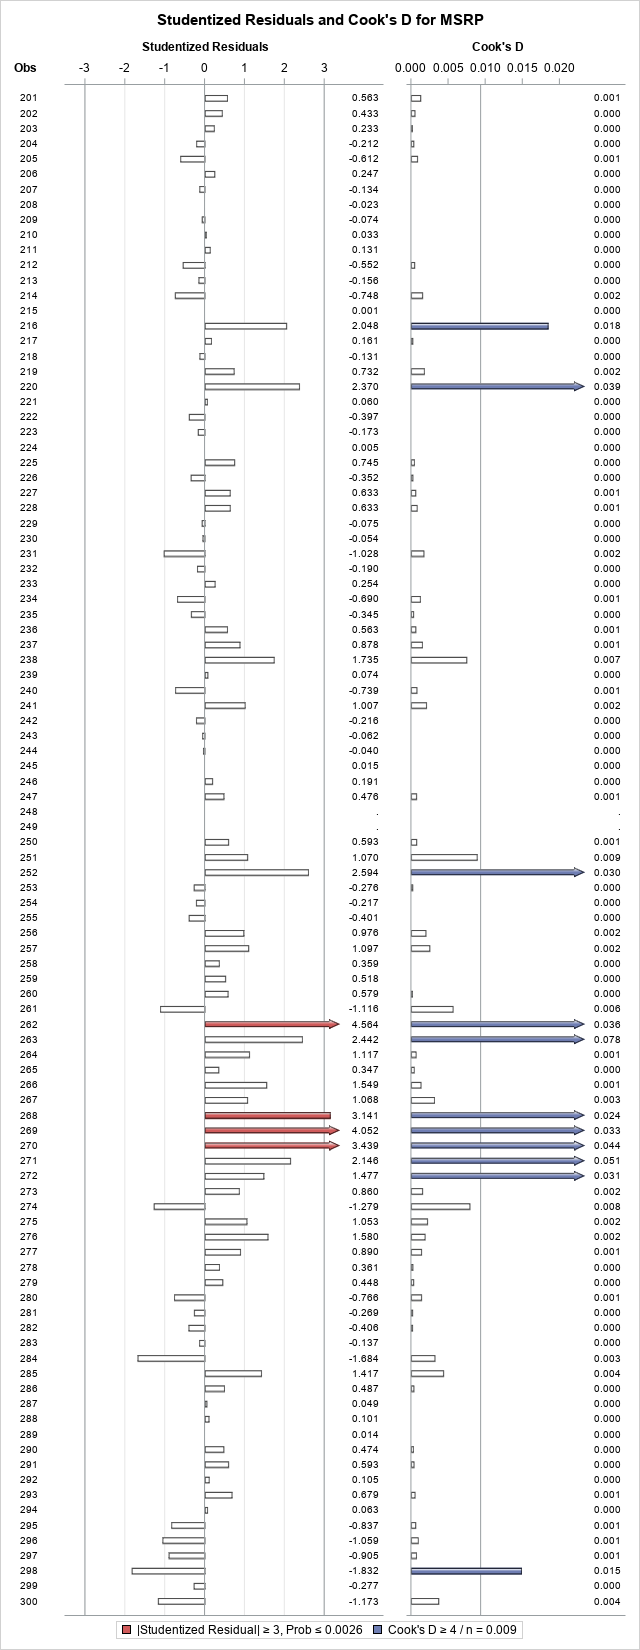
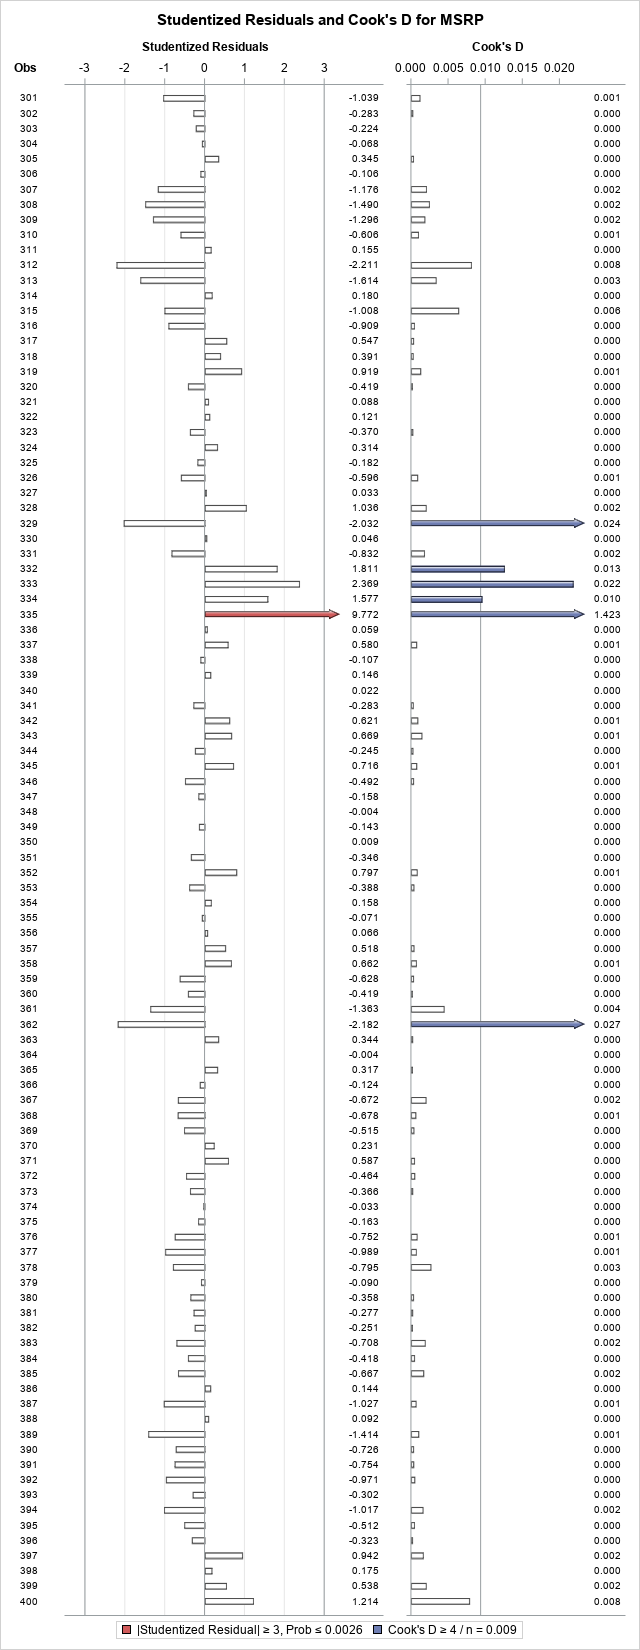
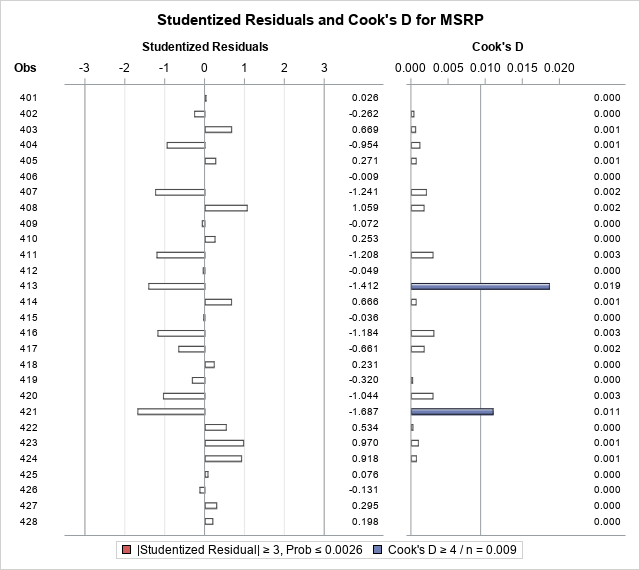
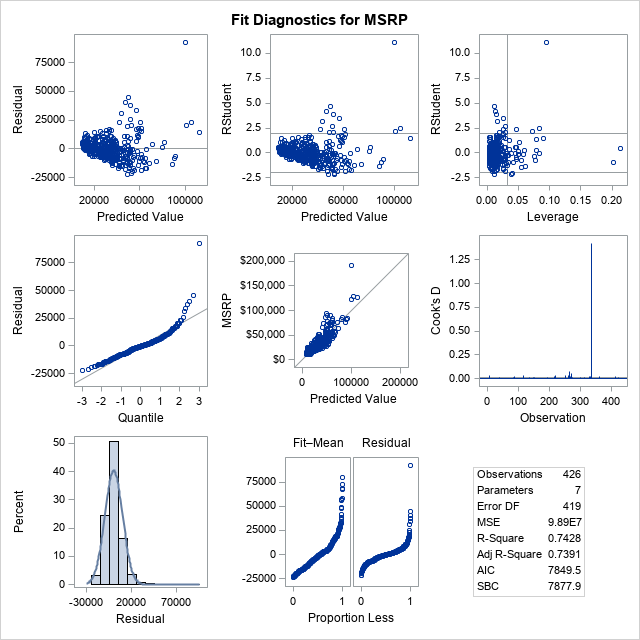
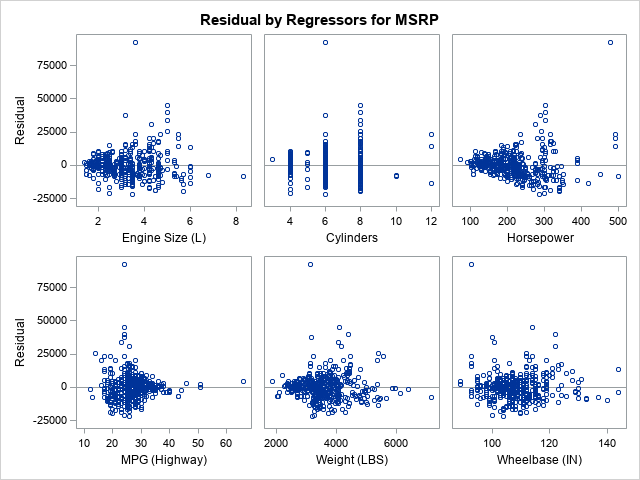

In [8]:
reg_result=sas.submit("""proc reg data = sashelp.cars plots=diagnostics(stats=(default aic sbc));
model MSRP = EngineSize Cylinders Horsepower MPG_City MPG_Highway Weight Wheelbase Length / selection=stepwise
run;""")
HTML(reg_result['LST'])

In [9]:
sas.datasets('sasuser')

5                                                          The SAS System                             11:29 Monday, December 2, 2019

40         

NOTE: The PROCEDURE REG printed pages 1-2.
NOTE: PROCEDURE REG used (Total process time):
      real time           46.02 seconds
      cpu time            0.78 seconds
      

41         proc datasets dd=sasuser;
                                                             Directory

                                     Libref             SASUSER                                
                                     Engine             V9                                     
                                     Physical Name      C:\Users\sas\Documents\My SAS Files\9.4
                                     Filename           C:\Users\sas\Documents\My SAS Files\9.4
                                     Owner Name         BUILTIN\Administrators                 
                                     File Size          4KB                           

Check out the data in SAS

In [11]:
airline_sas = sas.sasdata('AIR', libref="sasuser")
airline_sas.tail()

,DATE,AIR
0,1960-08-01,606
1,1960-09-01,508
2,1960-10-01,461
3,1960-11-01,390
4,1960-12-01,432


In [15]:
# 6mths ahead
forecast_job= sas.submit(
    """proc esm data=sasuser.AIR out=work.AIRLINE_fcst lead=6; 
      id DATE interval=month;
      forecast AIR;
      run;"""
)
airline_forecast_sas = sas.sasdata('AIRLINE_fcst', libref="WORK")
airline_forecast_sas.tail(10)

,DATE,AIR
0,1960-09-01,508.000000
1,1960-10-01,461.000000
2,1960-11-01,390.000000
3,1960-12-01,432.000000
4,1961-01-01,431.958071
5,1961-02-01,431.958071
6,1961-03-01,431.958071
7,1961-04-01,431.958071
8,1961-05-01,431.958071
9,1961-06-01,431.958071


In [18]:
# Move the data to a datafranme and use as needed
airline_df = sas.sasdata2dataframe('AIR',libref="sasuser")
airline_df.head()

,DATE,AIR
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [19]:
airline_df = airline_df.set_index('DATE')

airline_df.index.freq = 'MS' # set Index frequency cal month begin

airline_df.head()

,AIR
DATE,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


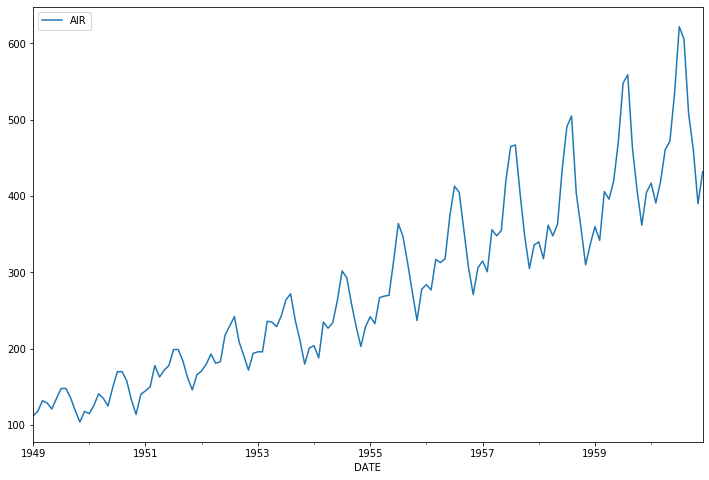

In [21]:
airline_df.plot(figsize=(12,8));

In [22]:
print(f"There are a total of {len(airline_df)} values in the dataset, we can split this to test and train") 
train_len = len(airline_df)-12
train = airline_df.iloc[:train_len]
test = airline_df.iloc[train_len:]
print(f"Post Split Training Data has the first {len(train)} values in the dataset, while the rest is in holdout")

There are a total of 144 values in the dataset, we can split this to test and train
Post Split Training Data has the first 132 values in the dataset, while the rest is in holdout


In [23]:
train.head()

,AIR
DATE,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Scale the Data before Fitting the Model

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [26]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [28]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [29]:
# fit model
model.fit_generator(generator,epochs=10)

Epoch 1/10
120/120 [==============================] - 5s 46ms/step - loss: 0.0388
Epoch 2/10
120/120 [==============================] - 5s 44ms/step - loss: 0.0135
Epoch 3/10
120/120 [==============================] - 5s 43ms/step - loss: 0.0108
Epoch 4/10
120/120 [==============================] - 6s 46ms/step - loss: 0.0095
Epoch 5/10
120/120 [==============================] - 5s 45ms/step - loss: 0.0092
Epoch 6/10
120/120 [==============================] - 5s 45ms/step - loss: 0.0109
Epoch 7/10
120/120 [==============================] - 5s 45ms/step - loss: 0.0095
Epoch 8/10
120/120 [==============================] - 5s 43ms/step - loss: 0.0105
Epoch 9/10
120/120 [==============================] - 5s 46ms/step - loss: 0.0071
Epoch 10/10
120/120 [==============================] - 6s 47ms/step - loss: 0.0048


In [30]:
model.history.history.keys()

dict_keys(['loss'])

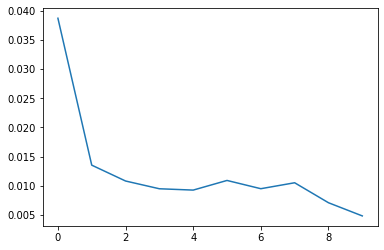

In [39]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [40]:
holdout_eval_batch1 = scaled_train[-12:]
holdout_eval_batch1

array([[0.56263736],
       [0.52307692],
       [0.66373626],
       [0.64175824],
       [0.69450549],
       [0.80879121],
       [0.97582418],
       [1.        ],
       [0.78901099],
       [0.66593407],
       [0.56703297],
       [0.66153846]])

In [43]:
test_predictions = []

holdout_eval_batch1 = scaled_train[-n_input:]
current_batch = holdout_eval_batch1.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [46]:
keras_forecast = scaler.inverse_transform(test_predictions)

In [49]:
keras_forecast

array([[441.3416391 ],
       [469.45684367],
       [499.80294877],
       [524.68407983],
       [591.56469309],
       [659.20941556],
       [719.76385558],
       [677.25671196],
       [604.38957775],
       [557.18401009],
       [559.52683532],
       [595.26235783]])

In [50]:
test['os_pred'] = keras_forecast

C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
test

,AIR,os_pred
DATE,,
1960-01-01,417,441.341639
1960-02-01,391,469.456844
1960-03-01,419,499.802949
1960-04-01,461,524.684080
1960-05-01,472,591.564693
1960-06-01,535,659.209416
1960-07-01,622,719.763856
1960-08-01,606,677.256712
1960-09-01,508,604.389578


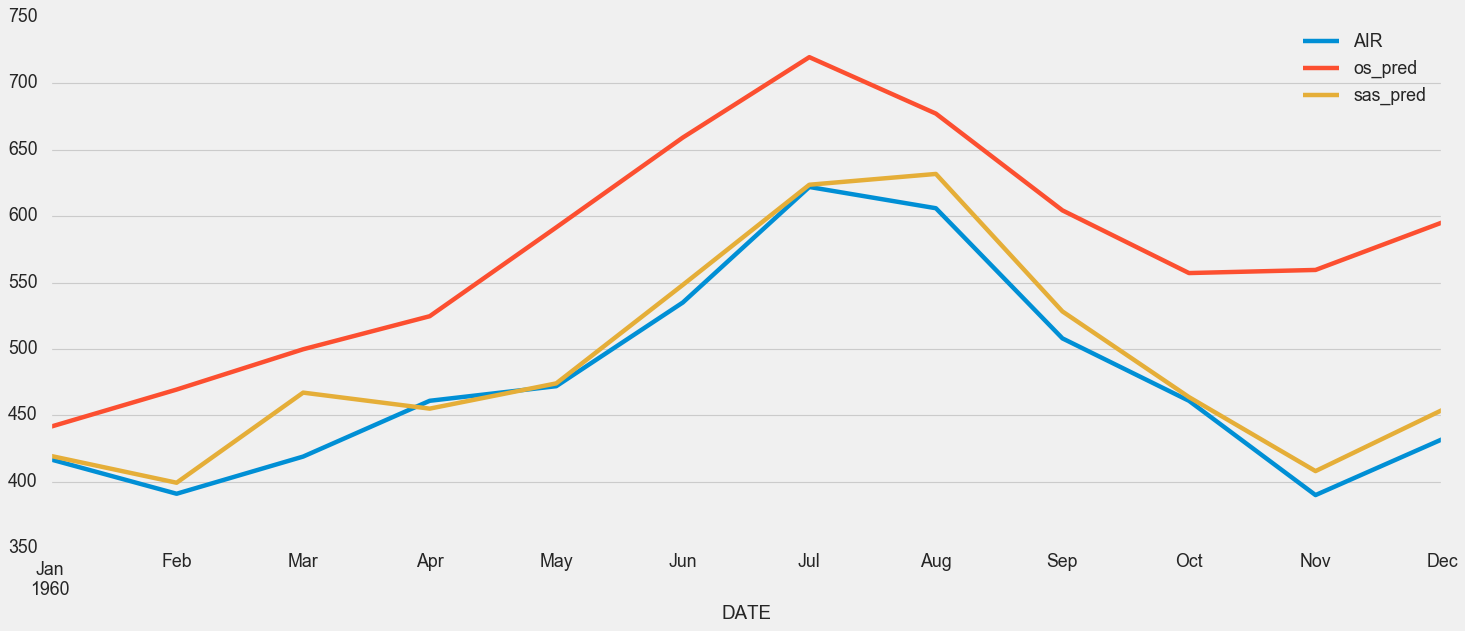

In [259]:
test.plot(figsize=(20,8));

In [85]:
train_sas = sas.df2sd(train.reset_index(),libref='work',table="air_train")

In [81]:
train_sas

Libref  = work
Table   = air_train
Dsopts  = {}
Results = Pandas

#### Perform a simple log transform

In [93]:
sas.submit(
    """data sasuser.air_train;
    set work.air_train;
    xlog = log( air );
    dt = datepart(date);
    format dt monyy.;
    run;"""
)

{'LOG': "\x0c109                                                        The SAS System                             11:29 Monday, December 2, 2019\n\n1675       ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;\n1675     ! ods graphics on / outputfmt=png;\nNOTE: Writing HTML5(SASPY_INTERNAL) Body file: _TOMODS1\n1676       \n1677       data sasuser.air_train;\n1678           set work.air_train;\n1679           xlog = log( air );\n1680           dt = datepart(date);\n1681           format dt monyy.;\n1682           run;\n\nNOTE: There were 132 observations read from the data set WORK.AIR_TRAIN.\nNOTE: The data set SASUSER.AIR_TRAIN has 132 observations and 4 variables.\nNOTE: DATA statement used (Total process time):\n      real time           0.04 seconds\n      cpu time            0.00 seconds\n      \n\n1683       \n1684       ods html5 (id=saspy_internal) close;ods listing;\n1685       ",
 'LST': ''}

#### Lets now do it the SAS Way. i.e Submit the sas forecast job from the notebook using SASPy

In [135]:
forecast_job= sas.submit(
        """proc arima data=sasuser.air_train;
       identify var=xlog(1,12);
       estimate q=(1)(12) noint method=ml;
       forecast id=dt interval=month printall lead=12 out=work.arima_forecast;
    run;  
      """
)
HTML(forecast_job['LOG'])

IF, we did this purely using **SASPy**

In [140]:
ets  = sas.sasets()

In [141]:
sas_arima = ets.arima(data = "sasuser.air_train",
          identify= "var=xlog(1,12)",
         estimate = "q=(1)(12) noint method=ml",
         forecast = "id=dt interval=month printall lead=12",
         out = "sasuser.arima_forecast")

In [142]:
dir(sas_arima) # Inpect the object

['CHISQAUTO',
 'CORRB',
 'DESCSTATS',
 'FITSTATISTICS',
 'FORECASTS',
 'FORECASTSONLYPLOT',
 'FORECASTSPLOT',
 'LOG',
 'MODELDESCRIPTION',
 'PARAMETERESTIMATES',
 'RESIDUALCORRPANEL',
 'RESIDUALNORMALITYPANEL',
 'RESIDUALPLOT',
 'SERIESCORRPANEL']


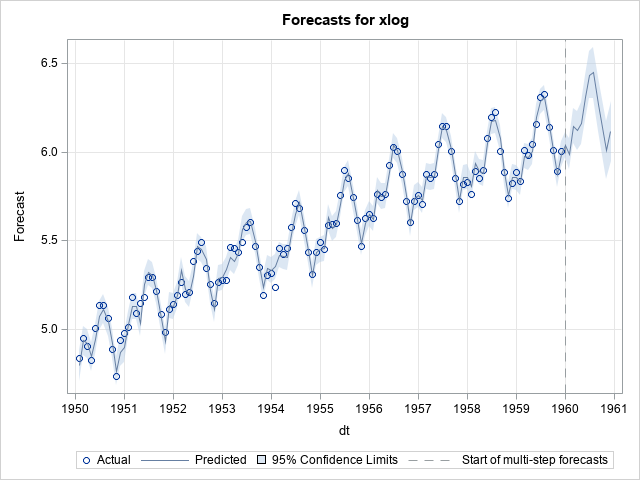

In [143]:
sas_arima.FORECASTSPLOT

In [138]:
rescale = sas.submit("""data sasuser.arima_res;
           set work.arima_forecast;
           x        = exp( xlog);
           forecast = exp( forecast + std*std/2 );
           l95      = exp( l95 );
           u95      = exp( u95 );
           run;""")
HTML(rescale['LOG'])

In [165]:
air_output = sas.sasdata(table ='arima_res', libref='sasuser')
air_output.tail()

,dt,xlog,FORECAST,STD,L95,U95,RESIDUAL,x
0,1960-08-01,NaN,631.824520,0.072811,546.347280,726.811522,NaN,NaN
1,1960-09-01,NaN,528.293614,0.076603,453.311422,612.076381,NaN,NaN
2,1960-10-01,NaN,463.779115,0.080216,395.033488,540.995865,NaN,NaN
3,1960-11-01,NaN,408.053667,0.083673,345.123172,479.093034,NaN,NaN
4,1960-12-01,NaN,454.010449,0.086993,381.393822,536.378512,NaN,NaN


In [166]:
sas_result = sas.sasdata2dataframe(table ='arima_res', libref='sasuser')

In [167]:
sas_result[['FORECAST','STD','L95','U95']].tail()

,FORECAST,STD,L95,U95
139,631.824520,0.072811,546.347280,726.811522
140,528.293614,0.076603,453.311422,612.076381
141,463.779115,0.080216,395.033488,540.995865
142,408.053667,0.083673,345.123172,479.093034
143,454.010449,0.086993,381.393822,536.378512


Tease out just what is needed

In [252]:
# sas_result['sas_pred'] = sas_result['FORECAST']
# sas_result['sas_pred'].loc[sas_result['sas_pred'].isnull()] = sas_result['x']

#Show me results during the hold out period
sas_forecast=sas_result[sas_result['FORECAST'].isnull()==False][-12:]
sas_forecast = sas_forecast.set_index('dt')
sas_forecast.index.freq = 'MS'
sas_forecast.head()

,xlog,FORECAST,STD,L95,U95,RESIDUAL,x,sas_pred
dt,,,,,,,,
1960-01-01,NaN,419.604621,0.036539,390.344784,450.455944,NaN,NaN,419.604621
1960-02-01,NaN,399.298970,0.043609,366.239837,434.515125,NaN,NaN,399.298970
1960-03-01,NaN,467.154040,0.049682,423.286656,514.296613,NaN,NaN,467.154040
1960-04-01,NaN,455.095706,0.055090,407.897303,506.216839,NaN,NaN,455.095706
1960-05-01,NaN,474.116170,0.060013,420.745664,532.335900,NaN,NaN,474.116170


In [253]:
test['sas_pred'] = sas_forecast['FORECAST']
test

,AIR,os_pred,sas_pred
DATE,,,
1960-01-01,417,441.341639,419.604621
1960-02-01,391,469.456844,399.298970
1960-03-01,419,499.802949,467.154040
1960-04-01,461,524.684080,455.095706
1960-05-01,472,591.564693,474.116170
1960-06-01,535,659.209416,548.259816
1960-07-01,622,719.763856,623.692074
1960-08-01,606,677.256712,631.824520
1960-09-01,508,604.389578,528.293614


Plot out the results

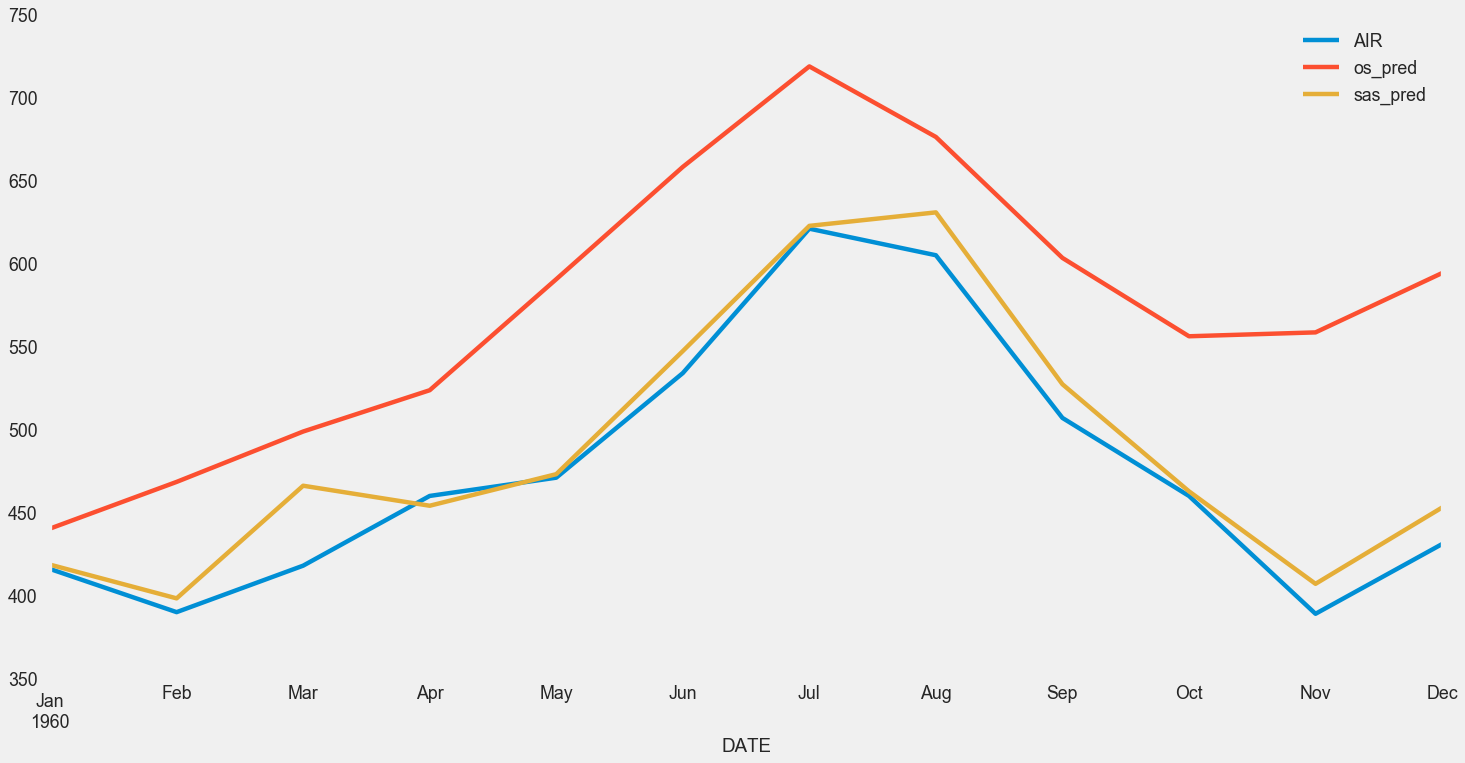

In [250]:
plt.style.use('fivethirtyeight')
test.plot(figsize=(20,10),);
plt.grid(False)

Calculate MAPE

In [258]:
def calc_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

print(f"INFO: MAPE for Keras Simple RNN is {calc_mape(test['AIR'],test['os_pred'])}")
print(f"INFO: MAPE for SAS ARIMA is {calc_mape(test['AIR'],test['sas_pred'])}")

INFO: MAPE for Keras Simple RNN is 21.343803272069863
INFO: MAPE for SAS ARIMA is 3.10855048412256
